# Homework 7 *\[submission template\]*

In [3]:
from dataclasses import dataclass
import enum

import numpy as np
import matplotlib.pyplot as plt

In [4]:
RNG = np.random.default_rng()
# your additional global initialization here

## §1. Implementing generic Markov chain simulations

#### CODE: `Model` interface

In [5]:
class Model:

    def transition_rate(self, state):
        """Total transition rate out of the given state"""
        raise NotImplementedError

    def sample_next(self, state):
        """Generates a random state to come after the given state"""
        raise NotImplementedError

#### CODE: simulating *discrete-time* Markov chains

In [6]:
def run_dtmc(model: Model, state_init, n_steps=256):
    path = [state_init]
    for i in range(n_steps):
        path.append(model.sample_next(path[-1]))
    # Return a list of (time, state) pairs
    # This simulation is discrete-time, so time is an integer
    return list(enumerate(path))

#### CODE: `QueueModel` example

In [7]:
@dataclass
class QueueModel(Model):
    """Model of a queue

    The state is the number of customers currently in the queue.

    Parameters
    ----------
    rate_arrival: float
        Rate at which customers arrive at the queue.

    rate_service: float
        Rate at which customers leave the queue when it is nonempty.
    """

    rate_arrival: float
    rate_service: float

    def transition_rate(self, state: int):
        if state == 0:
            return self.rate_arrival
        else:
            return self.rate_arrival + self.rate_service

    def sample_next(self, state: int):
        if RNG.random() < self.rate_arrival / self.transition_rate(state):
            return state + 1
        else:
            return state - 1

In [8]:
def visualize_queue_path(path):
    plt.plot(*np.asarray(path).T)

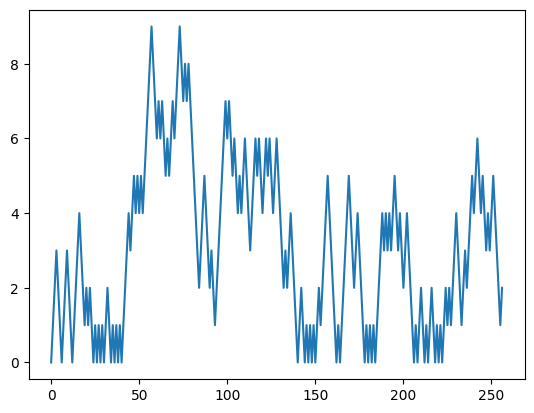

In [9]:
visualize_queue_path(run_dtmc(QueueModel(5, 6), 0))

#### ANSWER

In [10]:
def run_ctmc(model: Model, state_init: int, n_steps: int = 256):
    """
    Simulates a continuous-time Markov chain (CTMC) for a given model.
    
    Parameters
    ----------
        model (Model): 
            The Markov chain model, with `transition_rate` and `sample_next` methods.

        state_init (int): 
            The initial state of the chain.

        n_steps (int): 
            The number of steps to simulate.
        
    Returns:
        List[Tuple[float, int]]: A list of (time, state) pairs representing the path.
    """
    paths = [(0, state_init)] # Time, State
    
    for _ in range(n_steps):
        current_time, current_state = paths[-1]
        rate = model.transition_rate(current_state)
        
        time_step = RNG.exponential(1 / rate)
        new_state = model.sample_next(current_state)

        # To handle edge case where rate is 0
        if (type(time_step) not in [int,float]):
            time_step[np.isinf(time_step)] = 0
        
        new_path = (current_time + time_step, new_state)
        paths.append(new_path)
    
    return paths


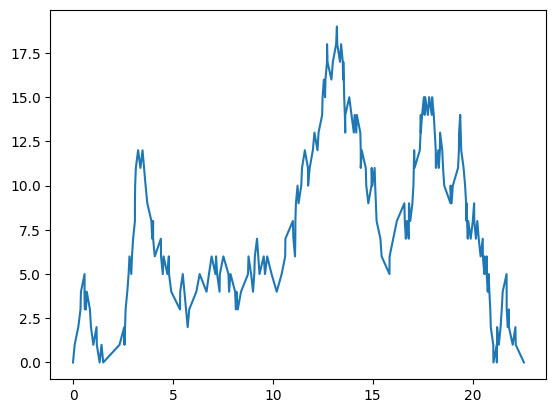

In [11]:
# An initial test
visualize_queue_path(run_ctmc(QueueModel(5, 6), 0))

## §2. Implementing initial model for the project

#### ANSWER

In [12]:
# Changed to be list of femalees for easier acceess and generalization
@dataclass(frozen=True)
class SimpleWorkplaceState:
    n_females:list

# Changed levels to be a list and added rate matrix and weight matrix
@dataclass(frozen=True)
class WorkplaceParams:
    n_levels:list
    rate_matrix:np.matrix
    weight_matrix:np.matrix
        
@dataclass(frozen=True)
class SimpleWorkplaceModel:
    params: WorkplaceParams

    def transition_rate(self, state: SimpleWorkplaceState):
        # Fixed transition matrix of all ones
        return self.params.rate_matrix
    

    def adjust_rate(self, state: SimpleWorkplaceState):
        """Ensures that more employees don't leave than currenetly employeed"""
        rate = self.transition_rate(state).copy()
        for i in range(rate.shape[0]):
            for j in range(rate.shape[1]):
                if (i == 0): # Male
                    rate[i,j] = min(rate[i,j], self.params.n_levels[j] - state.n_females[j])
                else:
                    rate[i,j] = min(rate[i,j], state.n_females[j])
        return rate

    def sample_next(self, state: SimpleWorkplaceState):
        rate = self.adjust_rate(state)
        weights = self.params.weight_matrix

        employees_gone = np.sum(rate, axis=0)  # Total employees leaving per level
        new_females = []
        
        for i in range(len(employees_gone) - 1, -1, -1):
            if i == 0:
                # Hire Newe
                new_hires = RNG.binomial(employees_gone[i], weights[1, i] / (weights[0, i] + weights[1, i]))
                new_females.append(new_hires)
            else:
                # Promote from last level
                f_prop = weights[0, i] * state.n_females[i - 1]
                m_prop = weights[1, i] * (self.params.n_levels[i - 1] - state.n_females[i - 1])
                if f_prop + m_prop > 0:
                    new_hires = RNG.binomial(employees_gone[i], f_prop / (f_prop + m_prop))
                else:
                    new_hires = 0  
                new_females.append(new_hires)

        # Reverse new_females to align with asceending level ordering
        new_females = np.array(new_females[::-1])

        # Limit the new female employees to be in [0,n_l]
        new_n_females = np.clip(state.n_females + new_females - rate[1, :], 0, self.params.n_levels)
        return SimpleWorkplaceState(list(new_n_females))


In [13]:
initial_state = SimpleWorkplaceState([100, 50, 10, 4])
initial_workplace = WorkplaceParams([200, 100, 20, 5], np.ones((2,4)), np.ones((2,4))) # Simple rates and weights
results = run_ctmc(SimpleWorkplaceModel(initial_workplace), initial_state, 1000)

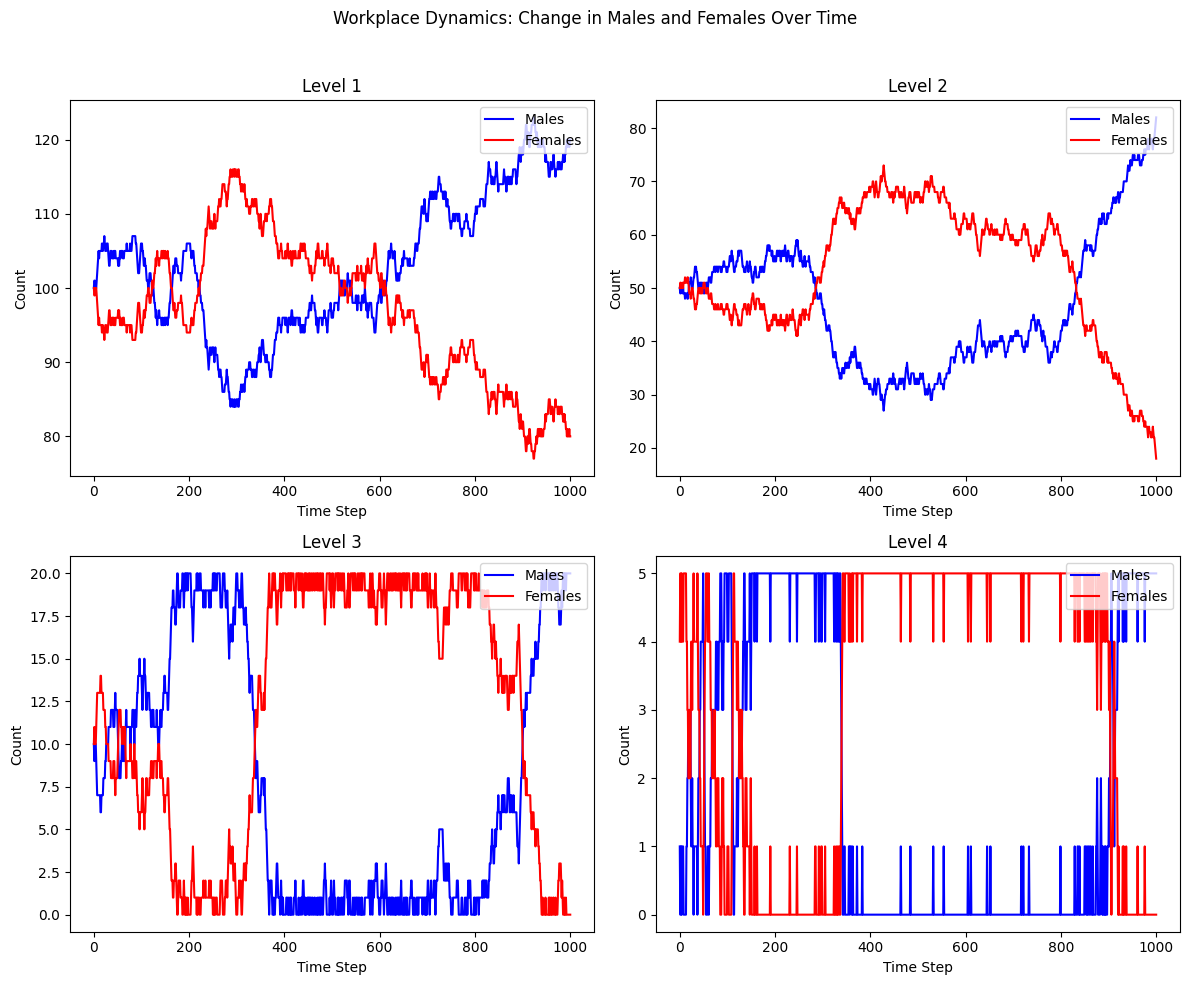

In [14]:
def plot_workplace_dynamics_line(data_list, level_sizes):
    """
    Plots the change in females and males over time for each level using a 2x2 subplot of line graphs.
    
    Args:
        data_list (list): 
            A list of tuples, where:
            - data_list[i][0] is the array with people leaving at each level at a given time step.
            - data_list[i][1] is a SimpleWorkplaceState object with the number of females.
    """
    n_levels = 4
    time_steps = len(data_list)
    
    # Extract females and males over time for each level
    females_over_time = []
    males_over_time = []
    
    for (time, state) in data_list:
        females_over_time.append(state.n_females)
        males_over_time.append(level_sizes - females_over_time[-1])
    
    females_over_time = np.array(females_over_time)
    males_over_time = np.array(males_over_time)
    
    # Create 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Workplace Dynamics: Change in Males and Females Over Time')
    
    for level in range(n_levels):
        row, col = divmod(level, 2)
        ax = axes[row, col]
        
        # Plot line graphs for males and females over time
        ax.plot(range(time_steps), males_over_time[:, level], label='Males', linestyle='-', color='blue')
        ax.plot(range(time_steps), females_over_time[:, level], label='Females', linestyle='-', color='red')
        
        # Set titles and labels
        ax.set_title(f'Level {level + 1}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Count')
        ax.legend(loc='upper right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

plot_workplace_dynamics_line(results, np.array(initial_workplace.n_levels))


## §3. Implementing a more extensible model for the project

#### ANSWER

In [15]:
class Identity(enum.Enum):
    FEMALE = enum.auto()
    MALE = enum.auto()

@dataclass(frozen=True)
class Employee:
    identity: Identity
    hiring_and_promotion_times: tuple[float, ...]

    @property
    def level(self):
        return len(self.hiring_and_promotion_times) - 1

    @property
    def current_level_time(self):
        return self.hiring_and_promotion_times[-1]

    @staticmethod
    def sample_new_hire(p_female, t_now):
        i = Identity.FEMALE if RNG.random() < p_female else Identity.MALE
        return Employee(i, (t_now,))

    def promoted(self, t_now):
        return Employee(
            self.identity,
            (*self.hiring_and_promotion_times, t_now),
        )

@dataclass
class ComplexWorkplaceState:
    employees_0: tuple[Employee, ...]
    employees_1: tuple[Employee, ...]
    employees_2: tuple[Employee, ...]
    employees_3: tuple[Employee, ...]

    def to_simple_state(self):
        return SimpleWorkplaceState(
            sum(1 for e in self.employees_0 if e.identity == Identity.FEMALE),
            sum(1 for e in self.employees_1 if e.identity == Identity.FEMALE),
            sum(1 for e in self.employees_2 if e.identity == Identity.FEMALE),
            sum(1 for e in self.employees_3 if e.identity == Identity.FEMALE),
        )

    # TODO: other methods?

@dataclass
class ComplexWorkplaceModel:
    params: WorkplaceParams

    def transition_rate(self, state: ComplexWorkplaceState):
        pass  # TODO

    def sample_next(self, state: ComplexWorkplaceState):
        pass  # TODO

    # TODO: maybe

In [16]:
# Testing conversion to simple state

ComplexWorkplaceState(
    (Employee.sample_new_hire(0.5, 42) for i in range(3)),
    (Employee.sample_new_hire(0.5, 42) for i in range(5)),
    (Employee.sample_new_hire(0.5, 42) for i in range(7)),
    (Employee.sample_new_hire(0.5, 42) for i in range(12)),
).to_simple_state()

TypeError: __init__() takes 2 positional arguments but 5 were given